In [2]:
NAME = "Arya Araban"
STUDENT_ID = "1439683"

In [3]:
%%capture

!pip install accelerate

!pip install sentence-transformers
!pip install rank_bm25
!pip install spacy-universal-sentence-encoder

In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.28.0

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)


#LOADING / PREPROCESSING

In [4]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import json

import os 
from google.colab import files

import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

import re

# Import libraries
import torch
import torch.utils 
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses
from sentence_transformers.readers import InputExample# Import libraries

from sentence_transformers import SentenceTransformer, SentencesDataset, losses
from sentence_transformers.readers import InputExample
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

from sklearn.metrics.pairwise import cosine_similarity


from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer, SentencesDataset, losses
from sentence_transformers.readers import InputExample
from sentence_transformers.models import Pooling, Dense

from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments

import pickle
import math 

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def json_to_df(file): 
  with open(file) as json_file:
     dict_df = json.load(json_file) 
     df = pd.DataFrame.from_dict(dict_df, orient="index") 
     df.reset_index(level=0, inplace=True) 
     return df

def df_to_json(df):
    df = df.set_index('index')
    json_data = df.to_json(orient='index')
    parsed = json.loads(json_data)
    return parsed

def save_json(json_data):
    filename = "data.json"
    i = 2
    while os.path.isfile(filename):
        filename = f"data{i}.json"
        i += 1
    with open(filename, "w") as f:
        json.dump(json_data, f)

In [7]:
train_claims = json_to_df('/content/drive/MyDrive/datasets/NLP_A3/train-claims.json')
dev_claims = json_to_df('/content/drive/MyDrive/datasets/NLP_A3/dev-claims.json')
test_claims = json_to_df('/content/drive/MyDrive/datasets/NLP_A3/test-claims-unlabelled.json')
evidence = json_to_df('/content/drive/MyDrive/datasets/NLP_A3/evidence.json')

evidence.columns = ['evidence_id', 'evidence_text'] + list(evidence.columns[2:])

In [8]:
# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Define a function to preprocess a sentence
def preprocess(sentence):
  # Tokenize the sentence using spaCy
  tokens = nlp(sentence)
  # Remove punctuation, stopwords and non-alphabetic words
  tokens = [token.lemma_ for token in tokens if not token.is_punct and not token.is_stop and token.is_alpha]
  # Join the tokens back into a sentence
  sentence = " ".join(tokens)
  # Return the modified sentence
  return sentence

# Test the function on an example sentence
sentence = "I have two datasets data. (here in the books they read clans) The first claim_text high-latitude one has text and evidences. aren't shouldn't cockroach "
print(preprocess(sentence))

  

dataset datum book read clan high latitude text evidence cockroach


In [ ]:
# Apply the clean_text function to the claim_text and evidence_text columns
train_claims["claim_text"] = train_claims["claim_text"].apply(preprocess)
dev_claims["claim_text"] = dev_claims["claim_text"].apply(preprocess)
test_claims["claim_text"] = test_claims["claim_text"].apply(preprocess)

if os.path.isfile('/content/drive/MyDrive/datasets/NLP_A3/evidence_preprocessed.csv'):
    evidence_preprocessed = pd.read_csv('/content/drive/MyDrive/datasets/NLP_A3/evidence_preprocessed.csv')
    evidence_preprocessed.drop(['Unnamed: 0'], axis=1, inplace=True)
else:
    evidence["evidence_text"] = evidence["evidence_text"].apply(preprocess) # be sure to save this after applying 
    evidence_preprocessed = evidence


In [10]:
# Concatenate dataframes on top of each other
traindev_claims = pd.concat([train_claims, dev_claims], ignore_index=True)

In [ ]:
train_claims

,index,claim_text,claim_label,evidences
0,claim-1937,scientific evidence pollutant high concentrati...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1..."
1,claim-126,El Niño drive record high global temperature s...,REFUTES,"[evidence-338219, evidence-1127398]"
2,claim-2510,PDO switch cool phase,SUPPORTS,"[evidence-530063, evidence-984887]"
3,claim-2021,Weather Channel co founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5..."
4,claim-2449,January cap month period global temperature dr...,NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72..."
...,...,...,...,...
1223,claim-1504,climate scientist aspect case Hurricane Harvey...,SUPPORTS,"[evidence-1055682, evidence-1047356, evidence-..."
1224,claim-243,assessment report IPCC estimate human emission...,SUPPORTS,[evidence-916755]
1225,claim-2302,mid global temperature warm degree celsius decade,NOT_ENOUGH_INFO,"[evidence-403673, evidence-889933, evidence-11..."
1226,claim-502,abnormal temperature spike February early mont...,NOT_ENOUGH_INFO,"[evidence-97375, evidence-562427, evidence-521..."


#PART1 - Evidence Retrieval

##Sentence Transformer (Fine-Tuning)

plan on fine tuning roberta sentence-transformer, which as input needs pairs of two sentences

In [ ]:
# Create a dictionary to map evidence numbers to evidence text
evidence_dict = evidence_preprocessed.set_index('evidence_id')['evidence_text'].to_dict()

# Define function to perform pairwise matching between claims and evidence
def get_retrieval_train_examples(claims_df, evidence_dict):
    train_examples = []
    for index, row in claims_df.iterrows():
        claim_text = row['claim_text']
        for evidence_num in row['evidences']:
            evidence_text = evidence_dict.get(evidence_num)
            train_examples.append(InputExample(texts=[claim_text, evidence_text]))
    return train_examples

# # Call function to get list of pairs

# pairs = match_claims_to_evidence(train_claims, evidence_dict)

In [ ]:
def fine_tune_model(num_epochs, batch_size, traindev=False):  # fine tune a set after finding optimal hyperparams
  clms = traindev_claims if traindev else train_claims
  train_examples = get_retrieval_train_examples(clms, evidence_dict) # MATCH EITHER train_claims OR traindev_claims
  model = SentenceTransformer('distilroberta-base') 

  train_dataset = SentencesDataset(train_examples, model)
  train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

  train_loss = losses.MultipleNegativesRankingLoss(model)
    # Train the model
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
            epochs=num_epochs,
            warmup_steps=100,
            output_path='model_output_trainval')
  return model 

In [ ]:
n_epochs= 5
n_batch = 32 
st_model = fine_tune_model(num_epochs=n_epochs,batch_size=n_batch,traindev=True) # try with num epochs 1 and 2 and batch 16 and 32. 
st_model.save('/content/drive/MyDrive/models/model_output_5_32_tv')

In [ ]:
# st_model = SentenceTransformer('model_output_trainval')

now testing the model.. by encoding all evidences.. (SPOILER: takes too long, wont work)

In [ ]:
claim = [train_claims.iloc[0]["claim_text"]]
evidence_lst = evidence_preprocessed["evidence_text"].tolist()

# Encode the claims and evidences
claim_embeddings = st_model.encode(claim, convert_to_tensor=True)
evidence_embeddings = st_model.encode(evidence_lst, convert_to_tensor=True)

# Compute the similarity scores
similarity_scores = util.cos_sim(claim_embeddings, evidence_embeddings)

instead use bm25 to find list of candidate solutions

In [ ]:
evidence_lst = evidence_preprocessed["evidence_text"].tolist()
evidence_index = {evidence: index for index, evidence in enumerate(evidence_lst)}
tokenized_evidence = [str(doc).split(" ") for doc in evidence_lst]
bm25 = BM25Okapi(tokenized_evidence)

In [ ]:
evidence_lst = evidence_preprocessed["evidence_text"].tolist()
evidence_index = {evidence: index for index, evidence in enumerate(evidence_lst)}
tokenized_evidence = [str(doc).split(" ") for doc in evidence_lst]
bm25 = BM25Okapi(tokenized_evidence)
# THIS IS THE MAIN FUNCTION FOR EVIDENCE RETRIEVAL PART OF PROJECT

def select_evidences(model, claim_set, candidate_amount=200, threshold = 0.85, add_on_empty=2): # try 82 and 225 as well later. 
  #THE HYPERPARAMETERS: 
  #candidate_amount: the  number of evidence candidates to find using bm25 algorithm 
  #threshold: similarity threshold. if claim and evidences had cosine similarity above threshold, then keep evidence 
  #add_on_empty: if no evidences were linked to claim, then add the top "add_on_empty" (based on cosine similarity)

  evidences = []

  claims = claim_set # EITHER dev_claims OR test_claims
  claim_lst = claims["claim_text"].tolist()
  claims_encodings = model.encode(claim_lst)

  for i,claim_text in enumerate(claim_lst): 
    
    tokenized_claim =str(claim_text).split(" ")
    top_matches = bm25.get_top_n(tokenized_claim, evidence_lst, n=candidate_amount)
    top_indices = [evidence_index[match] for match in top_matches]

    evidences_encodings = model.encode(top_matches)
    cur_claim_encoding = claims_encodings[i]

    # Normalize the claim embedding
    claim_norm = np.linalg.norm(cur_claim_encoding)
    cur_claim_encoding = cur_claim_encoding / claim_norm

    # Normalize the evidence embeddings
    evidence_norms = np.linalg.norm(evidences_encodings, axis=1)
    evidences_encodings = evidences_encodings / evidence_norms[:, None]

    cosine_scores = np.dot(cur_claim_encoding, evidences_encodings.T)
    above_threshold_evidences = []

    for j in range(len(top_matches)):
      cur_cosine_score = cosine_scores[j]

      if  cur_cosine_score > threshold:
        above_threshold_evidences.append(top_indices[j])

    if not above_threshold_evidences:
       top_indices_sorted_by_score = [top_indices[j] for j in np.argsort(cosine_scores)[::-1]]
       above_threshold_evidences.extend(top_indices_sorted_by_score[:add_on_empty]) #number of evidences to add 

    evidences.append(above_threshold_evidences)

  
  return evidences





In [ ]:
# st_model = SentenceTransformer('model_output_trainval')


In [ ]:
def add_evidence_string(lst): 
  modified_list = [["evidence-" + str(num) for num in inner_list] for inner_list in lst]
  return modified_list

In [ ]:
evd_mdl_5_32_200_85_2 = select_evidences(st_model,dev_claims) 

In [ ]:
dev_claims

,index,claim_text,claim_label,evidences
0,claim-752,South Australia expensive electricity world,SUPPORTS,"[evidence-67732, evidence-572512]"
1,claim-375,cent total annual global emission carbon dioxi...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2..."
2,claim-1266,mean world warm pre industrial time,SUPPORTS,"[evidence-889933, evidence-694262]"
3,claim-871,happen Zika good model second worrying effect ...,NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28..."
4,claim-2164,Greenland lose tiny fraction ice mass,REFUTES,"[evidence-52981, evidence-264761, evidence-947..."
...,...,...,...,...
149,claim-2400,suddenly label pollutant disservice gas play e...,REFUTES,"[evidence-409365, evidence-127519, evidence-85..."
150,claim-204,natural orbitally drive warming atmospheric ca...,NOT_ENOUGH_INFO,"[evidence-368192, evidence-261690, evidence-20..."
151,claim-1426,world coral reef barren state constant decline,NOT_ENOUGH_INFO,"[evidence-1124018, evidence-995813, evidence-1..."
152,claim-698,recent study lead Lawrence Livermore National ...,REFUTES,[evidence-660755]


In [ ]:
dev_output_df = dev_claims.copy()
dev_output_df["evidences"] = add_evidence_string(evd_mdl_5_32_200_85_2)
save_json(df_to_json(dev_output_df))

#PART2 - Classification

##pre-analysis

In [11]:
category_count = traindev_claims['claim_label'].value_counts()

categories = category_count.index

categories

Index(['SUPPORTS', 'NOT_ENOUGH_INFO', 'REFUTES', 'DISPUTED'], dtype='object')

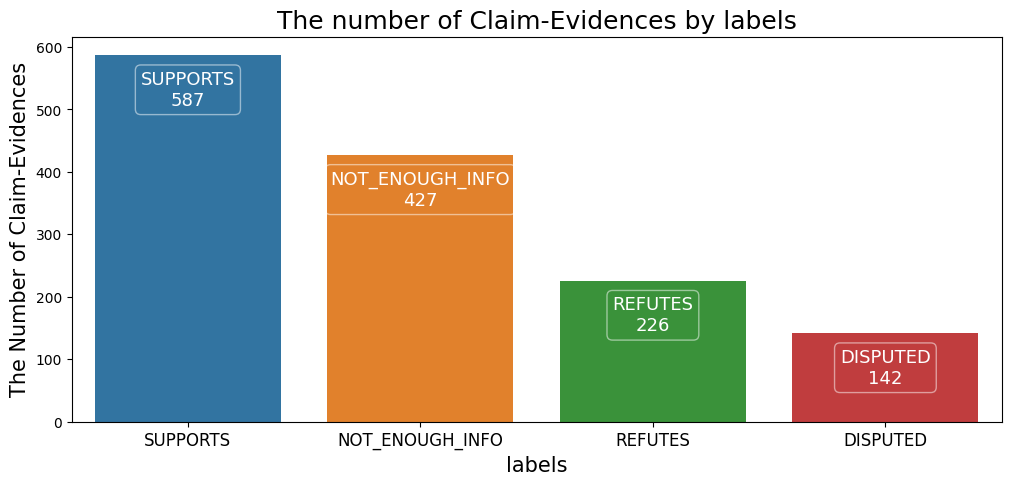

In [12]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('labels', size = 15)

plt.ylabel('The Number of Claim-Evidences', size= 15)

plt.xticks(size = 12)

plt.title("The number of Claim-Evidences by labels" , size = 18)

plt.show()

##fine-tuning (without class weights)

In [ ]:
evidence_dict = evidence_preprocessed.set_index('evidence_id')['evidence_text'].to_dict()
label_dict = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
rev_label_dict = {0:'SUPPORTS', 1: 'REFUTES', 2: 'NOT_ENOUGH_INFO', 3: 'DISPUTED'}

def get_full_sentence_labels_list(claims_df, separator_token, get_labels=True):
    sentences = []
    labels = [] 

    for index, row in claims_df.iterrows():
        cur_text = str(row['claim_text'])
        
        if get_labels:
            label_id = label_dict[row['claim_label']]
            labels.append(label_id)

        for evidence_num in row['evidences']:
            evidence_text = evidence_dict.get(evidence_num)
            cur_text += f" {separator_token} " + str(evidence_text)
        sentences.append(cur_text)
    
    return sentences, labels


In [ ]:
CLAIMS = traindev_claims #TRAIN OR TRAINDEV  - change accordingly split
max_length = 512

tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base", max_length = max_length) # Load tokenizer

sentences, labels = get_full_sentence_labels_list(CLAIMS, tokenizer.sep_token)

# max_length = max([len(s) for s in get_full_sentence_labels_list(traindev_claims, tokenizer.sep_token)[0]]) # Get the maximum length of sentences if problem, set to pre-set like 512 

inputs = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors="pt") # Tokenize sentences
inputs["labels"] = torch.tensor(labels) # Add labels to inputs

inputs = torch.utils.data.TensorDataset(inputs["labels"], inputs["input_ids"], inputs["attention_mask"])


In [ ]:
train_dataset = [{"labels": label, "input_ids": input_id, "attention_mask": attention_mask} for label, input_id, attention_mask in inputs]
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=4) 

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results", # Output directory for model checkpoints and evaluation results
    num_train_epochs=5, # Number of training epochs -- maybe change later 
    per_device_train_batch_size=16, # Batch size per device during training
    warmup_steps=250, # Number of warmup steps for learning rate scheduler
    weight_decay=1e-5, # Strength of weight decay
    logging_dir="./logs", # Directory for storing logs
    logging_steps=10, # Log every X updates steps
)

# Define trainer
trainer = Trainer(
    model=model, # The model to train and evaluate
    args=training_args, # Training arguments
    train_dataset=train_dataset, # Training dataset
)

In [ ]:
trainer.train()

In [ ]:
# from google.colab import files
# import shutil

# # Zip the saved model directory
# shutil.make_archive('saved_model', 'zip', 'saved_model')

# # Download the zip file to the local machine
# files.download('saved_model.zip')

now to do PREDICTIONS with this the model:

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")

classification_model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_model_tv")

def predict(input_texts):

  # Tokenize the input texts
  encoded_inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

  # Make predictions on the input texts
  classification_model.eval()
  with torch.no_grad():
      outputs = classification_model(encoded_inputs["input_ids"], attention_mask=encoded_inputs["attention_mask"])
      predicted_labels = torch.argmax(outputs.logits, dim=1)

  # Map the predicted labels to the corresponding string labels
  predicted_label_strs = [rev_label_dict[label.item()] for label in predicted_labels]
  return predicted_label_strs

#Bringing it all together (for TEST)

part1

In [ ]:
st_model = SentenceTransformer('/content/drive/MyDrive/models/model_output_5_32_tv') # COMMENT THIS IF LOADED ST FROM ACTUAL FINE TUNING 

In [ ]:
def add_evidence_string(lst): 
  modified_list = [["evidence-" + str(num) for num in inner_list] for inner_list in lst]
  return modified_list

In [ ]:
evidence_lst = evidence_preprocessed["evidence_text"].tolist()
evidence_index = {evidence: index for index, evidence in enumerate(evidence_lst)}
tokenized_evidence = [str(doc).split(" ") for doc in evidence_lst]
bm25 = BM25Okapi(tokenized_evidence)
# THIS IS THE MAIN FUNCTION FOR EVIDENCE RETRIEVAL PART OF PROJECT

def select_evidences(model, claim_set, candidate_amount=200, threshold = 0.85, add_on_empty=2): # try 82 and 225 as well later. 
  #THE HYPERPARAMETERS: 
  #candidate_amount: the  number of evidence candidates to find using bm25 algorithm 
  #threshold: similarity threshold. if claim and evidences had cosine similarity above threshold, then keep evidence 
  #add_on_empty: if no evidences were linked to claim, then add the top "add_on_empty" (based on cosine similarity)

  evidences = []

  claims = claim_set # EITHER dev_claims OR test_claims
  claim_lst = claims["claim_text"].tolist()
  claims_encodings = model.encode(claim_lst)

  for i,claim_text in enumerate(claim_lst): 
    
    tokenized_claim =str(claim_text).split(" ")
    top_matches = bm25.get_top_n(tokenized_claim, evidence_lst, n=candidate_amount)
    top_indices = [evidence_index[match] for match in top_matches]

    evidences_encodings = model.encode(top_matches)
    cur_claim_encoding = claims_encodings[i]

    # Normalize the claim embedding
    claim_norm = np.linalg.norm(cur_claim_encoding)
    cur_claim_encoding = cur_claim_encoding / claim_norm

    # Normalize the evidence embeddings
    evidence_norms = np.linalg.norm(evidences_encodings, axis=1)
    evidences_encodings = evidences_encodings / evidence_norms[:, None]

    cosine_scores = np.dot(cur_claim_encoding, evidences_encodings.T)
    above_threshold_evidences = []

    for j in range(len(top_matches)):
      cur_cosine_score = cosine_scores[j]

      if  cur_cosine_score > threshold:
        above_threshold_evidences.append(top_indices[j])

    if not above_threshold_evidences:
       top_indices_sorted_by_score = [top_indices[j] for j in np.argsort(cosine_scores)[::-1]]
       above_threshold_evidences.extend(top_indices_sorted_by_score[:add_on_empty]) #number of evidences to add 

    evidences.append(above_threshold_evidences)

  
  return evidences





In [ ]:
test_evidences = select_evidences(st_model,test_claims) 

In [ ]:
test_claims["evidences"] = add_evidence_string(test_evidences)

In [ ]:
test_claims

,index,claim_text,evidences
0,claim-1001,‘This study goes beyond statistical correlatio...,"[evidence-234136, evidence-626239]"
1,claim-1003,"A recent study in Nature Geoscience, for insta...","[evidence-122928, evidence-903119]"
2,claim-1009,‘Arctic ice conditions have been tracking at r...,"[evidence-482300, evidence-22578]"
3,claim-1020,“The global reef crisis does not necessarily m...,"[evidence-217138, evidence-731961]"
4,claim-1028,A second coat of paint has much less of an eff...,"[evidence-644769, evidence-550189]"
...,...,...,...
148,claim-910,"The cement, iron and steel, and petroleum refi...","[evidence-197221, evidence-1027569]"
149,claim-942,"‘We could be decades too fast, or decades too ...","[evidence-732482, evidence-874109]"
150,claim-952,The Alaskan tundra is warming so quickly it ha...,"[evidence-1069909, evidence-733164]"
151,claim-972,“Arctic land stores about twice as much carbon...,"[evidence-248795, evidence-964258]"


part2

In [ ]:
evidence_dict = evidence_preprocessed.set_index('evidence_id')['evidence_text'].to_dict()
label_dict = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
rev_label_dict = {0:'SUPPORTS', 1: 'REFUTES', 2: 'NOT_ENOUGH_INFO', 3: 'DISPUTED'}

def get_full_sentence_labels_list(claims_df, separator_token="</s>", get_labels=True):
    sentences = []
    labels = [] 

    for index, row in claims_df.iterrows():
        cur_text = str(row['claim_text'])
        
        if get_labels:
            label_id = label_dict[row['claim_label']]
            labels.append(label_id)

        for evidence_num in row['evidences']:
            evidence_text = evidence_dict.get(evidence_num)
            cur_text += f" {separator_token} " + str(evidence_text)
        sentences.append(cur_text)
    
    return sentences, labels


In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")

classification_model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_model_tv") #comment this if loaded from before 

def predict(input_texts):

  # Tokenize the input texts
  encoded_inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

  # Make predictions on the input texts
  classification_model.eval()
  with torch.no_grad():
      outputs = classification_model(encoded_inputs["input_ids"], attention_mask=encoded_inputs["attention_mask"])
      predicted_labels = torch.argmax(outputs.logits, dim=1)

  # Map the predicted labels to the corresponding string labels
  predicted_label_strs = [rev_label_dict[label.item()] for label in predicted_labels]
  return predicted_label_strs

In [ ]:
test_sentences, _ = get_full_sentence_labels_list(test_claims, get_labels=False)

In [ ]:
predicted = predict(test_sentences)

In [ ]:
test_claims["claim_label"] = predicted

In [ ]:
test_claims

,index,claim_text,evidences,claim_label
0,claim-1001,study go statistical correlation explore speci...,"[evidence-765446, evidence-868938]",SUPPORTS
1,claim-1003,recent study Nature Geoscience instance call q...,"[evidence-817308, evidence-903119]",SUPPORTS
2,claim-1009,arctic ice condition track record low conditio...,"[evidence-478846, evidence-849393]",SUPPORTS
3,claim-1020,global reef crisis necessarily mean extinction...,"[evidence-195294, evidence-217138]",SUPPORTS
4,claim-1028,second coat paint effect add fourth coat impact,"[evidence-310959, evidence-644769]",SUPPORTS
...,...,...,...,...
148,claim-910,cement iron steel petroleum refining industry ...,"[evidence-197221, evidence-117114]",SUPPORTS
149,claim-942,decade fast decade Robert DeConto University M...,"[evidence-955188, evidence-210377]",SUPPORTS
150,claim-952,alaskan tundra warm quickly net emitter carbon...,"[evidence-733164, evidence-1104389]",SUPPORTS
151,claim-972,Arctic land store twice carbon atmosphere,"[evidence-732232, evidence-825270]",REFUTES


In [ ]:
predicted_json = df_to_json(test_claims)

In [ ]:
save_json(predicted_json)